In [1]:
import kplr
import matplotlib.pyplot as plt
import numpy as np

# Curvas de luz de *Kepler*
## Misión Kepler
La misión de Kepler es explorar la estructura y diversidad de sistemas planetarios, esto se logra por un estudio de una muestra grande de estrellas, en los que destaca: (http://kepler.nasa.gov/Mission/QuickGuide/) 
* Determinar la abundancia de planetas terrestres cerca o dentro de la zona habitable de distintos tipos de estrellas.
* Detereminar la distribución de las formas y tamaños de las órbitas de los planetas.
* Estimar la cantidad de planetas que hay en sistemas de estrellas multiples.
* Determinar la variabilidad de los tamaños de la órbita y planetas reflectivos, tamaños masas y densidades de planetas gigantes de corto periodo.
* Identificar miembros adicionales de cada sistema planetario descubierto utilizando otras técnicas.
* Determinar las propiedades de las estrellas que albergan sistemas planetarios.


La misión K2 tiene como principal objetivo la observación de transitos planetarios, para poder encontrar planetas parecidos al nuestro y para resolver el paradigma de los "hot Jupiter"

Kepler object of interest (KOI), Kepler input catalogue (KIC) y Ecliptic plane input catalogue (EPIC)

In [45]:
%matplotlib inline
client = kplr.API()

IDs = [2305930, 4348593, 9469165, 7021124]#7198959]#
all_time, all_flux, all_flux_err = [], [], []
for element in IDs:
    kic = client.star(element)
    lcs = kic.get_light_curves()
    time, flux, flux_err = [], [], []
    for lc in lcs:
        with lc.open() as f:
            # The lightcurve data are in the first FITS HDU.
            hdu_data = f[1].data
            time.append(hdu_data["time"])
            flux.append(hdu_data["pdcsap_flux"])
            flux_err.append(hdu_data["pdcsap_flux_err"])
    all_time.append(time)
    all_flux.append(flux)
    all_flux_err.append(flux_err)


Se obtienen los parametros necesarios para realizar lo pedido,
La diferencia entre la fotometría *SAP* y *PDCSAP* es que esta última mediante un algoritmo quita de la imagen toda serie de errores sistemático (del telescopio) y de ruido preservando la señal de la fuente y otras cosas que son de interés

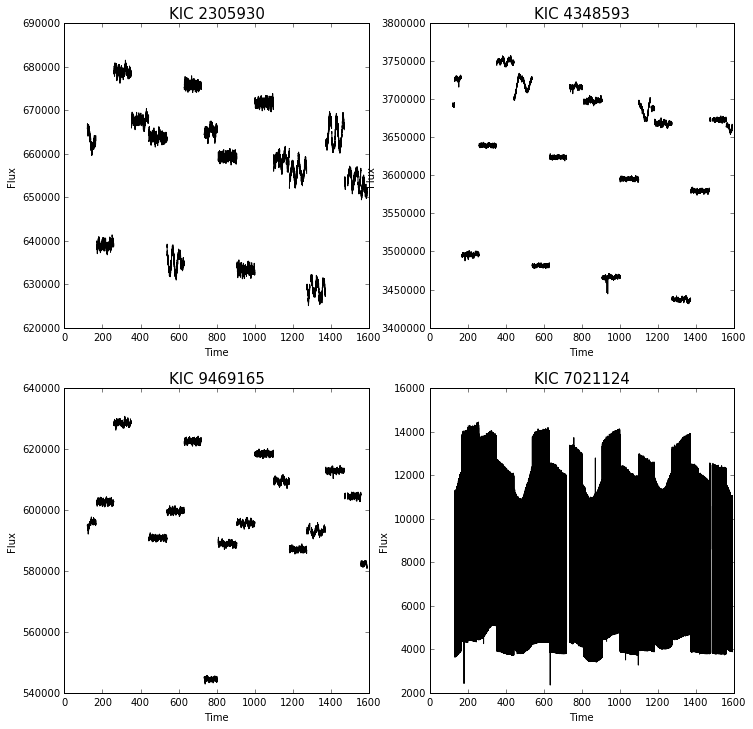

In [3]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[6*2, 6*2])


for i in range(0,len(all_time)):
    time = all_time[i]
    flux = all_flux[i]
    flux_err = all_flux_err[i]
    for j in range (0,len(time)):
        if i == 0: 
            ax[0,0].plot(time[j],flux[j],'k')
            ax[0,0].set(xlabel='Time', ylabel='Flux')
            ax[0,0].set_title("KIC 2305930",size = 15)
        elif i == 1:
            ax[0,1].plot(time[j],flux[j],'k')
            ax[0,1].set(xlabel='Time', ylabel='Flux')
            ax[0,1].set_title("KIC 4348593",size = 15)
        elif i == 2:
            ax[1,0].plot(time[j],flux[j],'k')
            ax[1,0].set(xlabel='Time', ylabel='Flux')
            ax[1,0].set_title("KIC 9469165",size = 15)
        elif i == 3:
            ax[1,1].plot(time[j],flux[j],'k')
            ax[1,1].set(xlabel='Time', ylabel='Flux')
            ax[1,1].set_title("KIC 7021124",size = 15)

In [4]:
def remove_nan_list(xarray,yarray,zarray):
    nans = np.isnan(yarray) #da un arreglo de boleanos de los elementos == np.nan
    index_nans = np.where(nans) #da los indices del arreglo donde la condicione es True (es un np.nan)
    for element in index_nans:
        xarray = np.delete(xarray,element)
        yarray = np.delete(yarray,element)
        zarray = np.delete(zarray,element)
    return xarray, yarray, zarray

def unir(time, flux, flux_err): #genera un unico arreglo sin np.nan y manteniendo las dimensiones de todos ellos igual
    total_time, total_flux, total_flux_err = [], [], []
    new_time, new_flux, new_flux_err = remove_nan_list(time[0],flux[0],flux_err[0])
    total_time = np.concatenate((total_time,new_time),axis=0)
    total_flux = np.concatenate((total_flux,new_flux),axis=0)
    total_flux_err = np.concatenate((total_flux_err,new_flux_err),axis=0)
    offset = 0

    for i in range(0,len(time)-1):
        last_flux = new_flux
        new_time, new_flux, new_flux_err =remove_nan_list(time[i+1],flux[i+1],flux_err[i+1])
        offset = np.median(new_flux) - np.median(last_flux)# la resta de esos puntos dice cuan corrida esta la siguiente de la actual
        new_line = new_flux - offset# la curva siguiente es movida al termino de la curva actual
        new_flux = new_line
        total_time = np.concatenate((total_time,new_time),axis=0)
        total_flux = np.concatenate((total_flux,new_flux),axis=0)
        total_flux_err = np.concatenate((total_flux_err,new_flux_err),axis=0)

    return total_time, total_flux, total_flux_err 

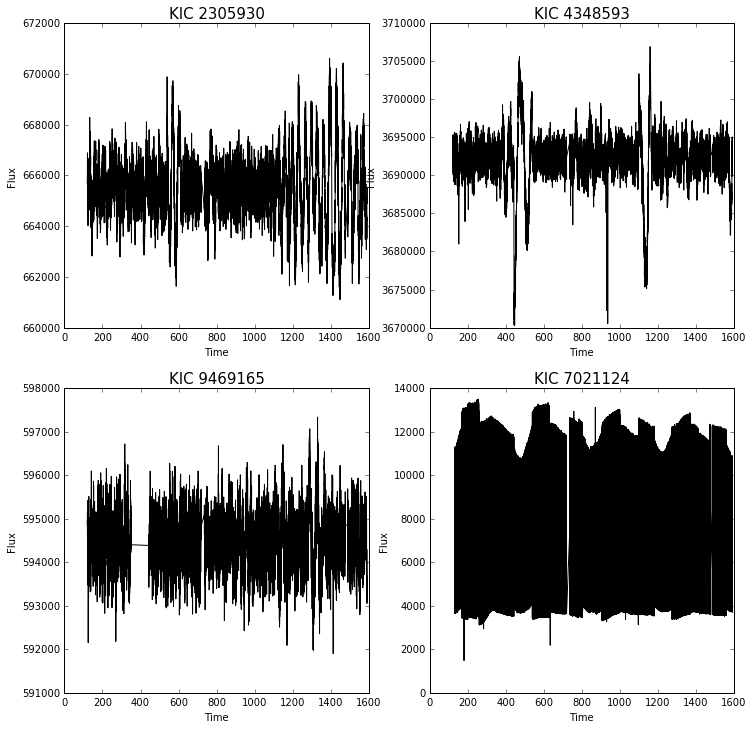

In [5]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[6*2, 6*2])
for i in range(0,len(all_time)):
    time = all_time[i]
    flux = all_flux[i]
    flux_err = all_flux_err[i]
    time, flux, flux_err = unir(time,flux,flux_err)
    if i == 0: 
        ax[0,0].plot(time,flux,'k')
        ax[0,0].set(xlabel='Time', ylabel='Flux')
        ax[0,0].set_title("KIC 2305930",size = 15)
        all_time[i] = time
        all_flux[i] = flux
        all_flux_err[i] = flux_err
    elif i == 1: 
        ax[0,1].plot(time,flux,'k')
        ax[0,1].set(xlabel='Time', ylabel='Flux')
        ax[0,1].set_title("KIC 4348593",size = 15)
        all_time[i] = time
        all_flux[i] = flux
        all_flux_err[i] = flux_err
    elif i == 2: 
        ax[1,0].plot(time,flux,'k')
        ax[1,0].set(xlabel='Time', ylabel='Flux')
        ax[1,0].set_title("KIC 9469165",size = 15)
        all_time[i] = time
        all_flux[i] = flux
        all_flux_err[i] = flux_err
    elif i == 3: 
        ax[1,1].plot(time,flux,'k')
        ax[1,1].set(xlabel='Time', ylabel='Flux')
        ax[1,1].set_title("KIC 7021124",size = 15)
        all_time[i] = time
        all_flux[i] = flux
        all_flux_err[i] = flux_err

Finding optimal frequency:
 - Estimated peak width = 0.00427
 - Using 5 steps per peak; omega_step = 0.000855
 - User-specified period range:  0.0023 to 0.03
 - Computing periods at 3018124 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00427
 - Using 5 steps per peak; omega_step = 0.000855
 - User-specified period range:  0.0023 to 0.03
 - Computing periods at 3017974 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00427
 - Using 5 steps per peak; omega_step = 0.000855
 - User-specified period range:  0.0024 to 0.03
 - Computing periods at 2812824 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  0.0049 to 1
 - Computing periods at 1489294 steps
Zooming-in on 5 ca

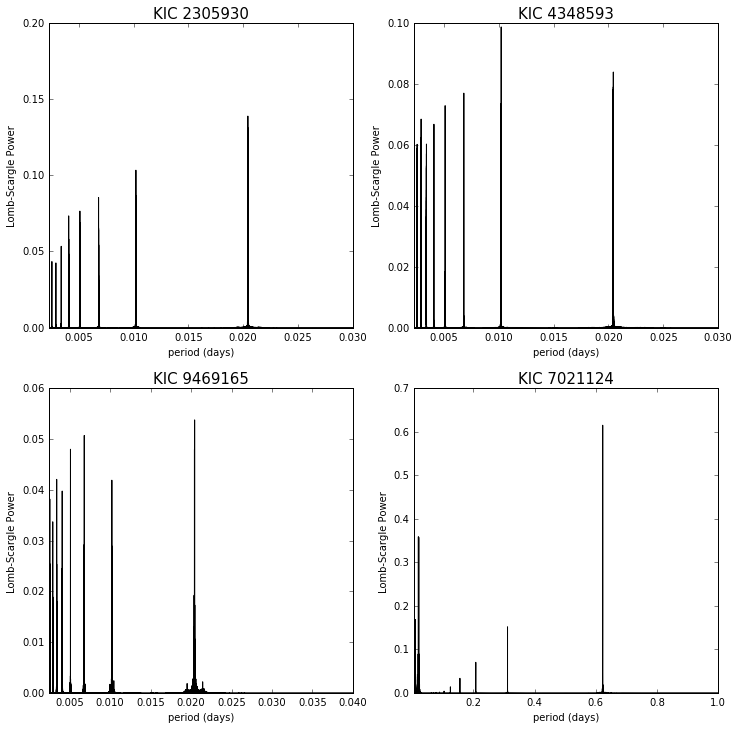

In [18]:
from gatspy.periodic import LombScargleFast

def periodograma(time,flux,flux_err,maxi,num):
    model = LombScargleFast().fit(time, flux, flux_err)
    periods, power = model.periodogram_auto(nyquist_factor=num)
    model.optimizer.period_range=(np.min(periods), maxi)
    period = model.best_period
    return periods, power, period

def my_pers():
    all_periods = []
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[6*2, 6*2])
    for i in range(0,len(all_time)):
        time = all_time[i]
        flux = all_flux[i]
        flux_err = all_flux_err[i]
        if i == 0:
            periods, power, period = periodograma(time,flux,flux_err,0.03,20)
            ax[0,0].plot(periods,power,'k')
            ax[0,0].set(xlim=(np.min(periods),0.03), xlabel='period (days)', ylabel='Lomb-Scargle Power')
            ax[0,0].set_title("KIC 2305930",size = 15)
        elif i == 1: 
            periods, power, period = periodograma(time,flux,flux_err,0.03,20)
            ax[0,1].plot(periods,power,'k')
            ax[0,1].set(xlim=(np.min(periods),0.03), xlabel='period (days)', ylabel='Lomb-Scargle Power')
            ax[0,1].set_title("KIC 4348593",size = 15)
        elif i == 2: 
            periods, power, period = periodograma(time,flux,flux_err,0.03,20)
            ax[1,0].plot(periods,power,'k')
            ax[1,0].set(xlim=(np.min(periods),0.04), xlabel='period (days)', ylabel='Lomb-Scargle Power')
            ax[1,0].set_title("KIC 9469165",size = 15)
        elif i == 3: 
            periods, power, period = periodograma(time,flux,flux_err,1.0,2)
            ax[1,1].plot(periods,power,'k')
            ax[1,1].set(xlim=(np.min(periods),1.0), xlabel='period (days)', ylabel='Lomb-Scargle Power')
            ax[1,1].set_title("KIC 7021124",size = 15)
        all_periods.append(period)
    return np.array(all_periods)
    
all_periods = my_pers()
print '\n================================================='
for i in range(0,len(all_periods)):
    print "KIC",IDs[i]
    print "period =",all_periods[i]
    print '\n'
print '================================================='


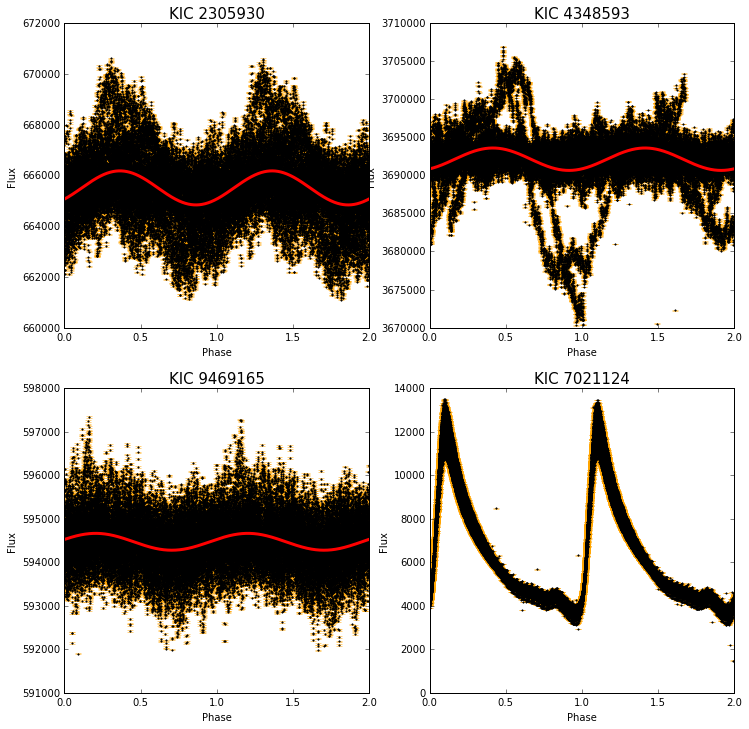

In [21]:
from scipy.interpolate import interp1d

def fasear(time,flux,flux_err,period):
    phase = (time / period) % 2
    model = LombScargleFast().fit(time, flux, flux_err)
    x = np.linspace(0, 2, 1000)
    y = model.predict(period * x, period=period)
    return phase, x, y
'''
    ap = []
    i = np.min(phase)
    bin_w = 0.01
    while i < np.max(phase):
        aux = []
        for element in phase:
            if element > i and element < i + bin_w:
                aux.append([(2*i + bin_w)/2, flux[np.where(phase==element)[0][0]] ])
        if aux != []:
            ap.append(np.array(aux))
        i += bin_w

    x = []
    y = []
    for element in ap:
        tiempo = element[:,1]
        mediana = np.median(tiempo)
        y.append(mediana)
        flujo = element[:,0]
        x.append(np.extract(mediana,flujo)[0])

    x = np.array(x)
    y = np.array(y) 


    f = interp1d(x, y, kind='cubic')
    xnew = np.linspace(np.min(x), np.max(x), 20, endpoint=True)
    return phase, xnew, f(xnew)
'''

def fasear_todo():
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[6*2, 6*2])
    for i in range(0,len(all_time)):
        time = all_time[i]
        flux = all_flux[i]
        flux_err = all_flux_err[i]
        period = all_periods[i]
        phase, x, y = fasear(time,flux,flux_err,period)
        if i == 0: 
            ax[0,0].errorbar(phase, flux,flux_err, fmt='.k', ecolor='orange',alpha=1,  ms = 3)
            ax[0,0].set(xlabel='Phase', ylabel='Flux')
            ax[0,0].plot(x, y, 'r', lw=3)
            ax[0,0].set_title("KIC 2305930",size = 15)
        elif i == 1: 
            ax[0,1].errorbar(phase, flux,flux_err, fmt='.k', ecolor='orange',alpha=1,  ms = 3)
            ax[0,1].set(xlabel='Phase', ylabel='Flux')
            ax[0,1].plot(x, y, 'r', lw=3)
            ax[0,1].set_title("KIC 4348593",size = 15)
        elif i == 2: 
            ax[1,0].errorbar(phase, flux,flux_err, fmt='.k', ecolor='orange',alpha=1,  ms = 3)
            ax[1,0].set(xlabel='Phase', ylabel='Flux')
            ax[1,0].plot(x, y, 'r', lw=3)
            ax[1,0].set_title("KIC 9469165",size = 15)
        elif i == 3: 
            ax[1,1].errorbar(phase, flux,flux_err, fmt='.k', ecolor='orange',alpha=1,  ms = 3)
            ax[1,1].set(xlabel='Phase', ylabel='Flux')
            #ax[1,1].plot(x, y, 'r', lw=3)
            ax[1,1].set_title("KIC 7021124",size = 15)
            
fasear_todo()


In [8]:
a = np.array([1,np.nan,3,4,5,np.nan])
c = np.array([1,2,3,4,5,6])
print np.where(np.isnan(a))[0]
z = np.delete(c,0)
print z

[1 5]
[2 3 4 5 6]


http://www-astro.physik.tu-berlin.de/plato-2011/talks/PLATO_SC2011_S08T03_Szabo.pdf

https://arxiv.org/pdf/1106.6120v1.pdf